<a href="https://www.kaggle.com/code/micheldc55/tutorial-deep-learning-mlp-clasificacion?scriptVersionId=113717804" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# REDES NEURONALES - CLASIFICACION

### Librerías

Las librerías utilizadas en este ejemplo son:

In [1]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt

# Preprocesado y modelado
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import scikitplot as skplt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, classification_report
from sklearn.metrics import roc_auc_score
# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')

## Datos

El set de datos Carseats, original del paquete de R ISLR y accesible en Python a través de statsmodels.datasets.get_rdataset, contiene información sobre la venta de sillas infantiles en 400 tiendas distintas. Para cada una de las 400 tiendas se han registrado 11 variables. Se pretende generar un modelo de clasificación que permita predecir si una tienda tiene ventas altas (Sales > 8) o bajas (Sales <= 8) en función de todas las variables disponibles.

Nota: este dataset proviene originalmente del paquete R!

In [2]:
datos = pd.read_csv('../input/carseats-data-r/dataset_car_seats.csv').drop('Unnamed: 0', axis=1)
datos.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


Como Sales es una variable continua y el objetivo del estudio es clasificar las tiendas según si venden mucho o poco, se crea una nueva variable dicotómica (0, 1) llamada ventas_altas.

In [3]:
datos['ventas_altas'] = np.where(datos.Sales > 8, 0, 1)
# Una vez creada la nueva variable respuesta se descarta la original
datos = datos.drop(columns = 'Sales')

In [4]:
datos

,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,ventas_altas
0,138,73,11,276,120,Bad,42,17,Yes,Yes,0
1,111,48,16,260,83,Good,65,10,Yes,Yes,0
2,113,35,10,269,80,Medium,59,12,Yes,Yes,0
3,117,100,4,466,97,Medium,55,14,Yes,Yes,1
4,141,64,3,340,128,Bad,38,13,Yes,No,1
...,...,...,...,...,...,...,...,...,...,...,...
395,138,108,17,203,128,Good,33,14,Yes,Yes,0
396,139,23,3,37,120,Medium,55,11,No,Yes,1
397,162,26,12,368,159,Medium,40,18,Yes,Yes,1
398,100,79,7,284,95,Bad,50,12,Yes,Yes,1


### Ajuste del modelo

En estos datos hay variables categóricas por lo que, antes de entrenar el modelo, es necesario aplicar one-hot-encoding.

In [5]:
# División de los datos en train y test
# ------------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop(columns = 'ventas_altas'),
                                        datos['ventas_altas'],
                                        random_state = 123
                                    )

# One-hot-encoding de las variables categóricas
# ------------------------------------------------------------------------------
# Se identifica el nobre de las columnas numéricas y categóricas
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()

# Se aplica one-hot-encoding solo a las columnas categóricas
preprocessor = ColumnTransformer(
                    [('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                    remainder='passthrough'
               )

# Una vez que se ha definido el objeto ColumnTransformer, con el método fit()
# se aprenden las transformaciones con los datos de entrenamiento y se aplican a
# los dos conjuntos con transform(). Ambas operaciones a la vez con fit_transform().
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

El resultado devuelto por ColumnTransformer es un numpy array, por lo que se pierden los nombres de las columnas. Suele ser interesante poder inspeccionar cómo queda el set de datos tras el preprocesado en formato dataframe. Por defecto, OneHotEncoder ordena las nuevas columnas de izquierda a derecha por orden alfabético.

In [6]:
# Convertir el output del ColumnTransformer en dataframe y añadir el nombre de las columnas
# ------------------------------------------------------------------------------
# Nombre de todas las columnas
encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names(cat_cols)
labels = np.concatenate([numeric_cols, encoded_cat])

# Conversión a dataframe
X_train_prep = pd.DataFrame(X_train_prep, columns=labels)
X_test_prep  = pd.DataFrame(X_test_prep, columns=labels)
X_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CompPrice         300 non-null    float64
 1   Income            300 non-null    float64
 2   Advertising       300 non-null    float64
 3   Population        300 non-null    float64
 4   Price             300 non-null    float64
 5   Age               300 non-null    float64
 6   Education         300 non-null    float64
 7   ShelveLoc_Bad     300 non-null    float64
 8   ShelveLoc_Good    300 non-null    float64
 9   ShelveLoc_Medium  300 non-null    float64
 10  Urban_No          300 non-null    float64
 11  Urban_Yes         300 non-null    float64
 12  US_No             300 non-null    float64
 13  US_Yes            300 non-null    float64
dtypes: float64(14)
memory usage: 32.9 KB


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [7]:
# Creación del modelo
# ------------------------------------------------------------------------------
modelo = MLPClassifier()

# Entrenamiento del modelo
# ------------------------------------------------------------------------------
modelo.fit(X_train_prep, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPClassifier()

### Predicción y evaluación del modelo

Se evalúa la capacidad predictiva del modelo inicial calculando el accuracy en el conjunto de test.

In [8]:
# Error de test del modelo
#-------------------------------------------------------------------------------
predicciones = modelo.predict(X = X_test_prep,)

print("Matriz de confusión")
print("-------------------")
confusion_matrix(
    y_true    = y_test,
    y_pred    = predicciones
)

Matriz de confusión
-------------------


array([[39, 11],
       [ 6, 44]])

In [9]:
accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )
print(f"El accuracy de test es: {100 * accuracy} %")

El accuracy de test es: 83.0 %


El modelo inicial es capaz de predecir correctamente un 72 % de las observaciones del conjunto de test.



In [10]:
print("accuracy: ", accuracy_score(y_test, predicciones))
print("AUC: ", roc_auc_score(y_test, predicciones))
print("CM: \n")
print(confusion_matrix(y_test, predicciones))
# classification report for precision, recall f1-score and accuracy
matrix = classification_report(y_test, predicciones)
print('Classification report Test: \n',matrix)

accuracy:  0.83
AUC:  0.83
CM: 

[[39 11]
 [ 6 44]]
Classification report Test: 
               precision    recall  f1-score   support

           0       0.87      0.78      0.82        50
           1       0.80      0.88      0.84        50

    accuracy                           0.83       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100



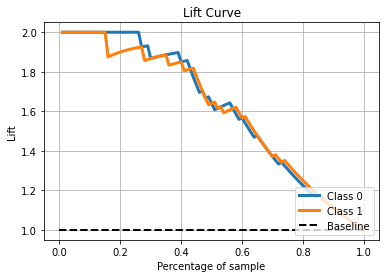

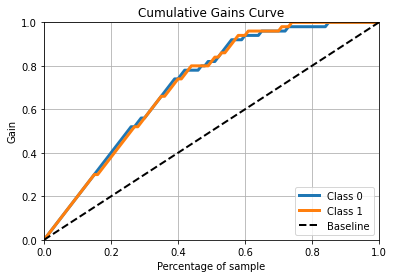

In [11]:
Y_test_pred_ = modelo.predict_proba(X_test_prep)[:]
skplt.metrics.plot_lift_curve(y_test, Y_test_pred_)
plt.show()
skplt.metrics.plot_cumulative_gain(y_test, Y_test_pred_)
plt.show()

### Ejecutamos un GridSearch 

Variamos las opciones que tiene MLPClassifier para encontrar una red que clasifique mejor

In [12]:
# Post pruning (const complexity pruning) por validación cruzada
# ------------------------------------------------------------------------------
# Valores de ccp_alpha evaluados
param_grid = {'hidden_layer_sizes': (80, 100, 120),
              'learning_rate_init': (0.01, 0.001)
             }

# Búsqueda por validación cruzada
grid = GridSearchCV(
        # ponemos los hiperparámetros iniciales de la red
        estimator = MLPClassifier(),
        param_grid = param_grid,
        scoring    = 'accuracy',
        cv         = 10,
        refit      = True,
        return_train_score = True
      )

grid.fit(X_train_prep, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multi

GridSearchCV(cv=10, estimator=MLPClassifier(),
             param_grid={'hidden_layer_sizes': (80, 100, 120),
                         'learning_rate_init': (0.01, 0.001)},
             return_train_score=True, scoring='accuracy')

In [13]:
# Mejor valor ccp_alpha encontrado
# ------------------------------------------------------------------------------
grid.best_params_

{'hidden_layer_sizes': 120, 'learning_rate_init': 0.001}

Se reentrena la red indicando los valores óptimos en sus argumentos. Si en el GridSearchCV() se indica refit=True, este reentrenamiento se hace automáticamente y el modelo resultante se encuentra almacenado en .best_estimator_.

In [14]:
# Estructura de la red final
# ------------------------------------------------------------------------------
modelo_final = grid.best_estimator_

In [15]:
len(y_train)

300

In [16]:
predicciones_train = modelo_final.predict(X = X_train_prep)

accuracy = accuracy_score(
            y_true    = y_train,
            y_pred    = predicciones_train,
            normalize = True
           )
print(f"El accuracy de train es: {100 * accuracy} %")

El accuracy de train es: 90.33333333333333 %


In [17]:
# Error de test del modelo final
#-------------------------------------------------------------------------------
predicciones = modelo_final.predict(X = X_test_prep)

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )
print(f"El accuracy de test es: {100 * accuracy} %")

El accuracy de test es: 82.0 %


In [18]:
print("accuracy: ", accuracy_score(y_test, predicciones))
print("AUC: ", roc_auc_score(y_test, predicciones))
print("CM: \n")
print(confusion_matrix(y_test, predicciones))
# classification report for precision, recall f1-score and accuracy
matrix = classification_report(y_test, predicciones)
print('Classification report Test: \n', matrix)

accuracy:  0.82
AUC:  0.82
CM: 

[[37 13]
 [ 5 45]]
Classification report Test: 
               precision    recall  f1-score   support

           0       0.88      0.74      0.80        50
           1       0.78      0.90      0.83        50

    accuracy                           0.82       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.83      0.82      0.82       100



Gracias al proceso de pruning el porcentaje de acierto ha pasando de 72% a 75%.



### Curvas Lift y ROC

Calculamos las curvas Lift y ROC para comprobar la calidad del modelo


In [19]:
import scikitplot as skplt

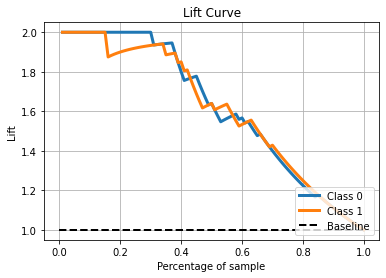

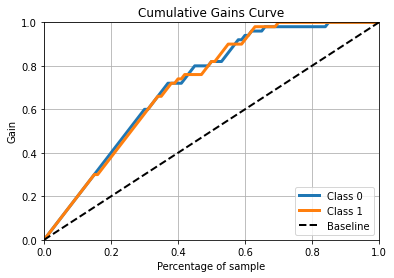

In [20]:
#Graficos
prediction_of_probability_test = modelo_final.predict_proba(X_test_prep)
skplt.metrics.plot_lift_curve(y_test, prediction_of_probability_test)
plt.show()
skplt.metrics.plot_cumulative_gain(y_test, prediction_of_probability_test)
plt.show()

### Predicción de probabilidades

La mayoría de implementaciones de los modelos basados en redes, entre ellas la de scikit-learn, permiten predicir probabilidades cuando se trata de problemas de clasificación. Es importante entender cómo se calculan estos valores para interpretarlos y utilizarlos correctamente.

En el ejemplo anterior, al aplicar .predict() se devuelve  1  (ventas elevadas) o  0  (ventas bajas) para cada observación de test. Sin embargo, no se dispone de ningún tipo de información sobre la seguridad con la que el modelo realiza esta asignación. Con .predict_proba(), en lugar de una clasificación, se obtiene la probabilidad con la que el modelo considera que cada observación puede pertenecer a cada una de las clases.

In [21]:
# Predicción de probabilidades
#-------------------------------------------------------------------------------
predicciones = modelo.predict_proba(X = X_test_prep)
predicciones[:5, :]

array([[0.44119366, 0.55880634],
       [0.9060316 , 0.0939684 ],
       [0.9746172 , 0.0253828 ],
       [0.16649419, 0.83350581],
       [0.8642885 , 0.1357115 ]])

El resultado de .predict_proba() es un array con una fila por observación y tantas columnas como clases tenga la variable respuesta. El valor de la primera columna se corresponde con la probabilidad, acorde al modelo, de que la observación pertenezca a la clase 0, y así sucesivamente. El valor de probabilidad mostrado para cada predicción se corresponde con la fracción de observaciones de cada classe en el nodo terminal al que ha llegado la observación predicha.

Por defecto, .predict() asigna cada nueva observación a la clase con mayor probabilidad (en caso de empate se asigna de forma aleatoria). Sin embargo, este no tiene por qué ser el comportamiento deseado en todos los casos.

In [22]:
# Clasificación empleando la clase de mayor probabilidad
# ------------------------------------------------------------------------------
df_predicciones = pd.DataFrame(data=predicciones, columns=['0', '1'])
df_predicciones['clasificacion_default_0.5'] = np.where(df_predicciones['0'] > df_predicciones['1'], 0, 1)
df_predicciones.head(3)

,0,1,clasificacion_default_0.5
0,0.441194,0.558806,1
1,0.906032,0.093968,0
2,0.974617,0.025383,0


Supóngase el siguiente escenario: la campaña de navidad se aproxima y los propietarios de la cadena quieren duplicar el stock de artículos en aquellas tiendas de las que se prevee que tengan ventas elevadas. Como el transporte de este material hasta las tiendas supone un coste elevado, el director quiere limitar esta estrategia únicamente a tiendas para las que se tenga mucha seguridad de que van conseguir muchas ventas.

Si se dispone de las probabilidades, se puede establecer un punto de corte concreto, por ejemplo, considerando únicamente como clase  1  (ventas altas) aquellas tiendas cuya predicción para esta clase sea superior al 0.8 (80%). De esta forma, la clasificación final se ajusta mejor a las necesidades del caso de uso.

In [23]:
# Clasificación final empleando un threshold de 0.8 para la clase 1.
# ------------------------------------------------------------------------------
df_predicciones['clasificacion_custom_0.8'] = np.where(df_predicciones['1'] > 0.8, 1, 0)
df_predicciones.iloc[5:10, :]

,0,1,clasificacion_default_0.5,clasificacion_custom_0.8
5,0.770942,0.229058,0,0
6,0.000554,0.999446,1,1
7,0.213787,0.786213,1,0
8,0.098653,0.901347,1,1
9,0.043068,0.956932,1,1


¿Hasta que punto se debe de confiar en estas probabilidades?

Es muy importante tener en cuenta la diferencia entre la visión que tiene el modelo del mundo y el mundo real. Todo lo que sabe un modelo sobre el mundo real es lo que ha podido aprender de los datos de entrenamiento y, por lo tanto, tiene una visión limitada. Por ejemplo, supóngase que, en los datos de entrenamiento, todas las tiendas que están en zona urbana Urban='Yes' tienen ventas altas independientemente del valor que tomen el resto de predictores. Cuando el modelo trate de predecir una nueva observación, si esta está en zona urbana, clasificará a la tienda como ventas elevadas con un 100% de seguridad. Sin embargo, esto no significa que sea inequivocamente cierto, podría haber tiendas en zonas úrbanas que no tienen ventas elevadas pero, al no estar presentes en los datos de entrenamiento, el modelo no contempla esta posibilidad.

Teniendo en cuenta todo esto, hay que considerar las probabilidades generadas por el modelo como la seguridad que tiene este, desde su visión limitada, al realizar las predicciones. Pero no como la probailidad en el mundo real de que así lo sea.
